### Задание 1: 
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [13]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [107]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X])

In [66]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

Немного изменим код из методички, потому что на выходе нам не нужны оценки ошибок по всем итерациям деревьев, а нужна общая оценка по модели

In [105]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_error = float()
    test_error = float()
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

        trees.append(tree)
    
    train_error = mean_squared_error(y_train, gb_predict(X_train, trees, eta))
    test_error = mean_squared_error(y_test, gb_predict(X_test, trees, eta))
        
    return trees, train_error, test_error

Создадим функцию для обучения модели и отрисовки графика по настраиваемым гиперпараметрам

In [102]:
def estimate_gradient_boost(data: list, eta=1, n_trees=10, max_depth=3):
    
    if n_trees == "estimate":
        train_errors = []
        test_errors = []
        for n_trees in range(1, 92, 10):
            trees, train, test = gb_fit(n_trees, max_depth, data[0], data[1], data[2], data[3], eta)
            train_errors.append(train)
            test_errors.append(test)
        
        plt.xlabel('Trees number')
        plt.ylabel('MSE')
        plt.xlim(0, 92)
        plt.plot(list(range(1, 92, 10)), train_errors, label='train error')
        plt.plot(list(range(1, 92, 10)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.show()
    
    elif max_depth == "estimate":
        train_errors = []
        test_errors = []
        for i in range(1, 16):
            trees, train, test = gb_fit(n_trees, i, data[0], data[1], data[2], data[3], eta)
            train_errors.append(train)
            test_errors.append(test)
        
        plt.xlabel('Max depth of trees')
        plt.ylabel('MSE')
        plt.xlim(1, 16)
        plt.plot(list(range(1, 16)), train_errors, label='train error')
        plt.plot(list(range(1, 16)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.show()
        
    else:
        trees, train, test = gb_fit(n_trees, max_depth, data[0], data[1], data[2], data[3], eta)
        return trees, train, test

In [35]:
data = [X_train, X_test, y_train, y_test]

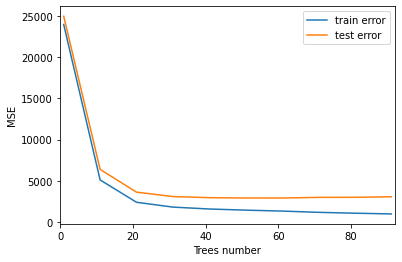

In [109]:
estimate_gradient_boost(data, eta=0.1, n_trees="estimate", max_depth=3)

исходя из полученных значений можно сделать вывод о том, что оптимальное количество деревьев для этих данных находится на уровне 20-21 дерева. Последующие деревья не вносят вклад в 

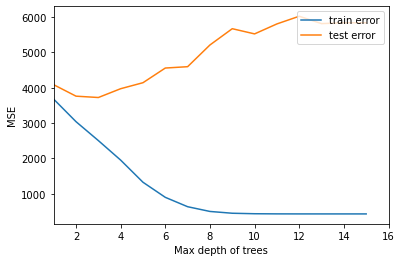

In [111]:
estimate_gradient_boost(data, eta=0.1, n_trees=20, max_depth="estimate")

Как видно из графика уеличение глубины деревьев приводит к увеличению переобучения. Так же деревья имеют сильную склонность к переобучению если нет критерия остановки в виде максимального количества листьев или максимального количества узлов, а в случае градиентного бустинга если увеличивать дерево то проблема переобучения увеличивается еще больше за счет градиента, поскольку алгоритм пытается минимизировать ошибку уже на переобученном дереве. Судя по графику на этих данных оптимальным будет уровень глубины дерева в три узла